In [1]:
import os
os.chdir("/home/wang/workspace/JupyterNoteBooksAll/fully-automated-multi-heartbeat-echocardiography-video-segmentation-and-motion-tracking")

%config Completer.use_jedi = False

import echonet
from echonet.datasets import Echo

import torch.nn.functional as F
from torchvision.models.video import r2plus1d_18
from torch.utils.data import Dataset, DataLoader, Subset
from multiprocessing import cpu_count

from src.utils.torch_utils import TransformDataset, torch_collate
from src.transform_utils import generate_2dmotion_field
from src.loss_functions import huber_loss, convert_to_1hot, convert_to_1hot_tensor
from src.model.R2plus1D_18_MotionNet import R2plus1D_18_MotionNet
from src.echonet_dataset import EchoNetDynamicDataset
from src.clasfv_losses import deformation_motion_loss, motion_seg_loss, DiceLoss, categorical_dice
from src.train_test import train, test

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

import random
import pickle
import time

tic, toc = (time.time, time.time)

with open("fold_indexes/stanford_train_sampled_indices", "rb") as infile:
    train_mask = pickle.load(infile)
infile.close()

with open("fold_indexes/stanford_valid_sampled_indices", "rb") as infile:
    valid_mask = pickle.load(infile)
infile.close()

batch_size = 4
num_workers = max(4, cpu_count()//2)

def worker_init_fn_valid(worker_id):                                                          
    np.random.seed(np.random.get_state()[1][0] + worker_id)
    

def worker_init_fn(worker_id):
    # See here: https://pytorch.org/docs/stable/notes/randomness.html#dataloader
    # and the original post of the problem: https://github.com/pytorch/pytorch/issues/5059#issuecomment-817373837
    worker_seed = torch.initial_seed() % 2 ** 32
    np.random.seed(worker_seed)
    random.seed(worker_seed)
    

def permuter(list1, list2):
    for i1 in list1:
        for i2 in list2:
            yield (i1, i2)
            

param_trainLoader = {'collate_fn': torch_collate,
                     'batch_size': batch_size,
                     'num_workers': max(4, cpu_count()//2),
                     'worker_init_fn': worker_init_fn}

param_testLoader = {'collate_fn': torch_collate,
                    'batch_size': batch_size,
                    'shuffle': False,
                    'num_workers': max(4, cpu_count()//2),
                    'worker_init_fn': worker_init_fn}

paramLoader = {'train': param_trainLoader,
               'valid': param_testLoader,
               'test':  param_testLoader}

train_dataset = EchoNetDynamicDataset(split='train', subset_indices=train_mask, period=1)
valid_dataset = EchoNetDynamicDataset(split='val', subset_indices=valid_mask, period=1)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, 
                              num_workers=num_workers, 
                              shuffle=True, pin_memory=("cuda"), 
                              worker_init_fn=worker_init_fn,
                              drop_last=True)

valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, 
                              num_workers=num_workers,
                              shuffle=False, pin_memory=("cuda"),
                              worker_init_fn=worker_init_fn_valid
                             )

100%|██████████| 16/16 [00:01<00:00, 13.45it/s]


In [2]:
model = torch.nn.DataParallel(R2plus1D_18_MotionNet())
model.to("cuda")

print(f'R2+1D MotionNet has {sum(p.numel() for p in model.parameters() if p.requires_grad)} parameters.')

lr_T = 1e-4 
optimizer = optim.Adam(model.parameters(), lr=lr_T)

R2+1D MotionNet has 31575731 parameters.


In [3]:
for batch_idx, batch in enumerate(train_dataloader, 1):
    break

In [4]:
Tensor = torch.cuda.FloatTensor

video_clips = torch.Tensor(batch[0])
video_clips = video_clips.type(Tensor)
filename, EF, es_clip_index, ed_clip_index, es_index, ed_index, es_frame, ed_frame, es_label, ed_label = batch[1]

In [5]:
# len(foo_list)

In [6]:
# filename, EF, es_clip_index, ed_clip_index, es_index, ed_index, es_frame, ed_frame, es_label, ed_label = foo_list

In [7]:
ed_frame.shape

torch.Size([4, 3, 112, 112])

There are 4 videos per batch, 3 channels per video, and all frames are 112 x 112 in the videos.

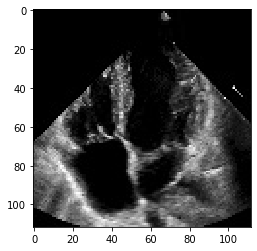

In [8]:
plt.imshow(ed_frame[0][0], cmap='gray')

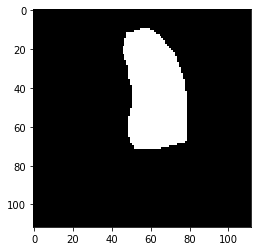

In [9]:
plt.imshow(ed_label[0], cmap='gray')

### This is the shape of the batch object that goes thru the model during training
#### What do these numbers mean?
4 - number of clips (batch_size)<br>
3 - channels<br>
32 - number of frames per clip<br>
112 x 112 - width x height<br>

### Now let's try to skip to the motion part in the training function

In [10]:
def motion_seg_loss(label_ed, label_es, ed_index, es_index, motion_output, seg_softmax, 
                    start=0, end=32, seg_criterion=DiceLoss()):
    """
        SGS loss that spatially transform the true ED and true ES fully forward to the end of video
        and backward to the beginning. Then, compare the forward and backward transformed pseudo labels with
        segmentation at all frames.
    """
    flow_source = convert_to_1hot(label_ed, 2)
    loss_forward = 0
    OTS_loss = 0
    OTS_criterion = DiceLoss()
    
    # Forward from ed to the end of video
    for frame_index in range(ed_index, end - 1):
        forward_motion = motion_output[:, :2, frame_index,...]
        motion_field = generate_2dmotion_field(flow_source, forward_motion)
        next_label = F.grid_sample(flow_source, motion_field, align_corners=False, mode="bilinear", padding_mode='border')
        
        if frame_index == (es_index - 1):
            one_hot_ES = convert_to_1hot(label_es, 2)
            OTS_loss += OTS_criterion(next_label, one_hot_ES)
        else:
            loss_forward += seg_criterion(seg_softmax[:, :, frame_index + 1, ...], next_label)
        flow_source = next_label
    
    # Forward from es to the end of video
    flow_source = convert_to_1hot(label_es, 2)
    for frame_index in range(es_index, end - 1):
        forward_motion = motion_output[:, :2, frame_index,...]
        motion_field = generate_2dmotion_field(flow_source, forward_motion)
        next_label = F.grid_sample(flow_source, motion_field, align_corners=False, mode="bilinear", padding_mode='border')

        loss_forward += seg_criterion(seg_softmax[:, :, frame_index + 1, ...], next_label)
        flow_source = next_label

    flow_source = convert_to_1hot(label_es, 2)
    loss_backward = 0
    
    # Backward from es to the beginning of video
    for frame_index in range(es_index, start, -1):
        backward_motion = motion_output[:, 2:, frame_index,...]
        motion_field = generate_2dmotion_field(flow_source, backward_motion)
        next_label = F.grid_sample(flow_source, motion_field, align_corners=False, mode="bilinear", padding_mode='border')
        
        if frame_index == ed_index + 1:
            one_hot_ED = convert_to_1hot(label_ed, 2)
            OTS_loss += OTS_criterion(next_label, one_hot_ED)
        else:
            loss_backward += seg_criterion(seg_softmax[:, :, frame_index - 1, ...], next_label)
        flow_source = next_label
    
    flow_source = convert_to_1hot(label_ed, 2)
    # Backward from ed to the beginning of video
    for frame_index in range(ed_index, start, -1):
        backward_motion = motion_output[:, 2:, frame_index,...]
        motion_field = generate_2dmotion_field(flow_source, backward_motion)
        next_label = F.grid_sample(flow_source, motion_field, align_corners=False, mode="bilinear", padding_mode='border')
        
        loss_backward += seg_criterion(seg_softmax[:, :, frame_index - 1, ...], next_label)
        flow_source = next_label
        
    # Averaging the resulting dice
    flow_loss = (loss_forward + loss_backward) / ((motion_output.shape[2] - 2) * 2)
    OTS_loss = OTS_loss / 2 
    
    return flow_loss, OTS_loss

In [11]:
# pass the current batch thru the model
video_clips = torch.Tensor(batch[0])
video_clips = video_clips.type(Tensor)
segmentation_output, motion_output = model(video_clips)

motion_seg_loss(label_ed = ed_label, 
                label_es = es_label, 
                ed_index = ed_index, 
                es_index = es_index, 
                motion_output = motion_output, 
                seg_softmax = seg_softmax, 
                start=0, 
                end=32, 
                seg_criterion=DiceLoss())


segmentation_one_loss, motion_one_loss = motion_seg_loss(label_ed, 
                                                         label_es, 
                                                         ed_one_index, 
                                                         es_one_index, 
                                                         motion_one_output, 
                                                         segmentation_one_output, 
                                                         0, video_clips.shape[2], 
                                                         F.binary_cross_entropy_with_logits)


NameError: name 'seg_softmax' is not defined